In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import SobolIndices, SobolKrigingIndices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_sensitivity_results

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = False
ylim = [-0.1, 0.7]

## The model

In [3]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami

## Sobol indices with a classical Monte-Carlo sampling

In [4]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 1000

# Evaluate the model
sobol = SobolIndices(model.input_distribution)
sobol.build_mc_sample(model=model, n_sample=n_sample)

In [5]:
n_boot = 500
estimator = 'soboleff2'

# Indice estimatino
sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_results.true_indices = ishigami.sobol_indices

# Results
first_indices_mc = sobol_results.first_indices
total_indices_mc = sobol_results.total_indices

print("Sobol indices:", first_indices_mc)
print("Total Sobol indices:", total_indices_mc)

Sobol indices: [ 0.25729118  0.41085608 -0.08663676]
Total Sobol indices: [ 0.51129078  0.36078461  0.14162998]


Let's see how it looks like in the plot

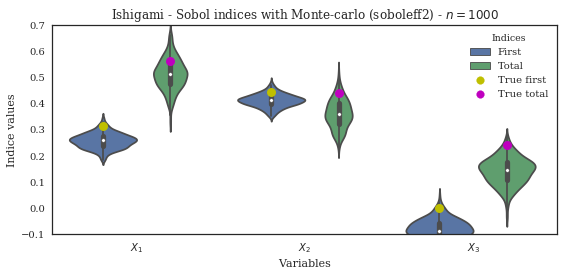

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results, ax=ax)
ax.set_title("Ishigami - Sobol indices with Monte-carlo (%s) - $n=%d$" % (estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_MC.pdf')

## Using a Kriging model to substitute the true model

### Building the model

In [7]:
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
model_budget = 50
basis = 'quadratic'
kernel = 'matern'
library = 'sklearn'
sobol_kriging = SobolKrigingIndices(model.input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel, library=library)

### The quality of the kriging model

#### With Leave One Out

In [8]:
score_q2_loo = meta_model.compute_score_q2_loo()
print('Leave One Out Q2 score:', score_q2_loo)

Leave One Out Q2 score: 0.286591074865


#### With cross validation

In [9]:
n_sample_cv = 1000
score_q2_cv = meta_model.compute_score_q2_cv(n_sample_cv, sampling='lhs')
print('Cross Validation Q2 score with %d observations:' % (n_sample_cv), score_q2_cv)

Cross Validation Q2 score with 1000 observations: 0.481948781052


### Estimating the indices

In [10]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
n_sample = 100
n_realization = 300

# Evaluate the kriging model
sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization)

Wall time: 69.2 ms


In [11]:
%%time
n_boot = 500
estimator = 'soboleff2'
sobol_kriging_results = sobol_kriging.compute_indices(n_boot=n_boot, estimator=estimator)
sobol_kriging_results.true_indices = ishigami.sobol_indices

# Results
first_indices_gp = sobol_kriging_results.first_indices
total_indices_gp = sobol_kriging_results.total_indices

print("Sobol indices:", first_indices_gp)
print("Total Sobol indices:", total_indices_gp)

Sobol indices: [ 0.3532585   0.15038575  0.13990608]
Total Sobol indices: [ 0.91632542  0.47013555  0.52851778]
Wall time: 1.06 s


#### Plot with the first and total indices

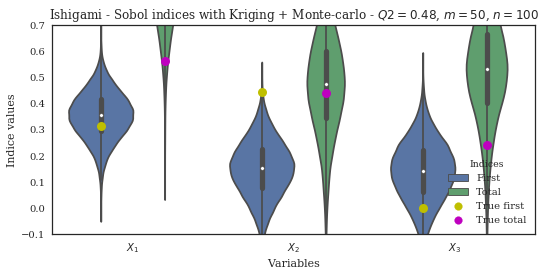

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_kriging_results, indice='both', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_sobol_GP.pdf')

#### Plots of the first indices with the kriging and monte-carlo errors

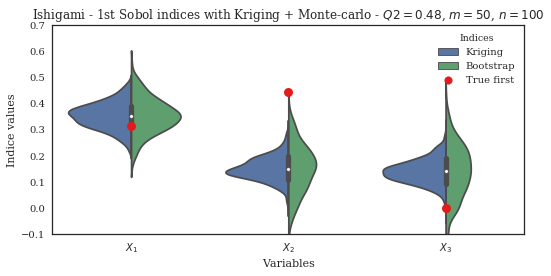

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results, indice='first', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - 1st Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_1st_sobol_GP.pdf')

#### Plots of the total indices with the kriging and monte-carlo errors

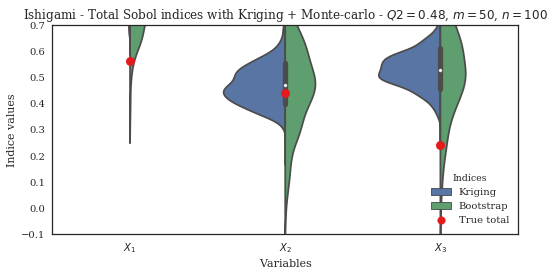

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
aa = plot_sensitivity_results(sobol_kriging_results, indice='total', ax=ax)
ax.set_ylim(ylim)
ax.set_title("Ishigami - Total Sobol indices with Kriging + Monte-carlo - $Q2=%.2f$, $m=%d$, $n=%d$" % (score_q2_cv, model_budget, n_sample))
fig.tight_layout()
if savefigs:
    fig.savefig('./output/ishigami_total_sobol_GP.pdf')